In [1]:
import json
import requests
from bs4 import BeautifulSoup
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from wordcloud import WordCloud

In [2]:
TRACKS_FILE_NAME = 'top_hits.json'

In [3]:
with open('../data/top_hits.json') as json_file:
    tracks = json.load(json_file)

In [4]:
df = pd.DataFrame(tracks)

In [5]:
df.shape

(2918, 33)

In [6]:
df['year']=df['album'].apply(lambda x: x.get('release_date')[:4])
df['decade'] = df['year'].apply(lambda x: x[:3]+'0')

In [7]:
df['primary_artist'] = df['artists'].apply(lambda x: x[0]['name'])

In [8]:
df['artists'] = df['artists'].apply(lambda x: [artist['name'] for artist in x])

In [9]:
df.columns

Index(['acousticness', 'album', 'analysis_url', 'artists', 'available_markets',
       'danceability', 'disc_number', 'duration_ms', 'energy', 'episode',
       'explicit', 'external_ids', 'external_urls', 'href', 'id',
       'instrumentalness', 'is_local', 'key', 'liveness', 'loudness', 'mode',
       'name', 'popularity', 'preview_url', 'speechiness', 'tempo',
       'time_signature', 'track', 'track_href', 'track_number', 'type', 'uri',
       'valence', 'year', 'decade', 'primary_artist'],
      dtype='object')

### Distributions

/home/mkrsteska/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


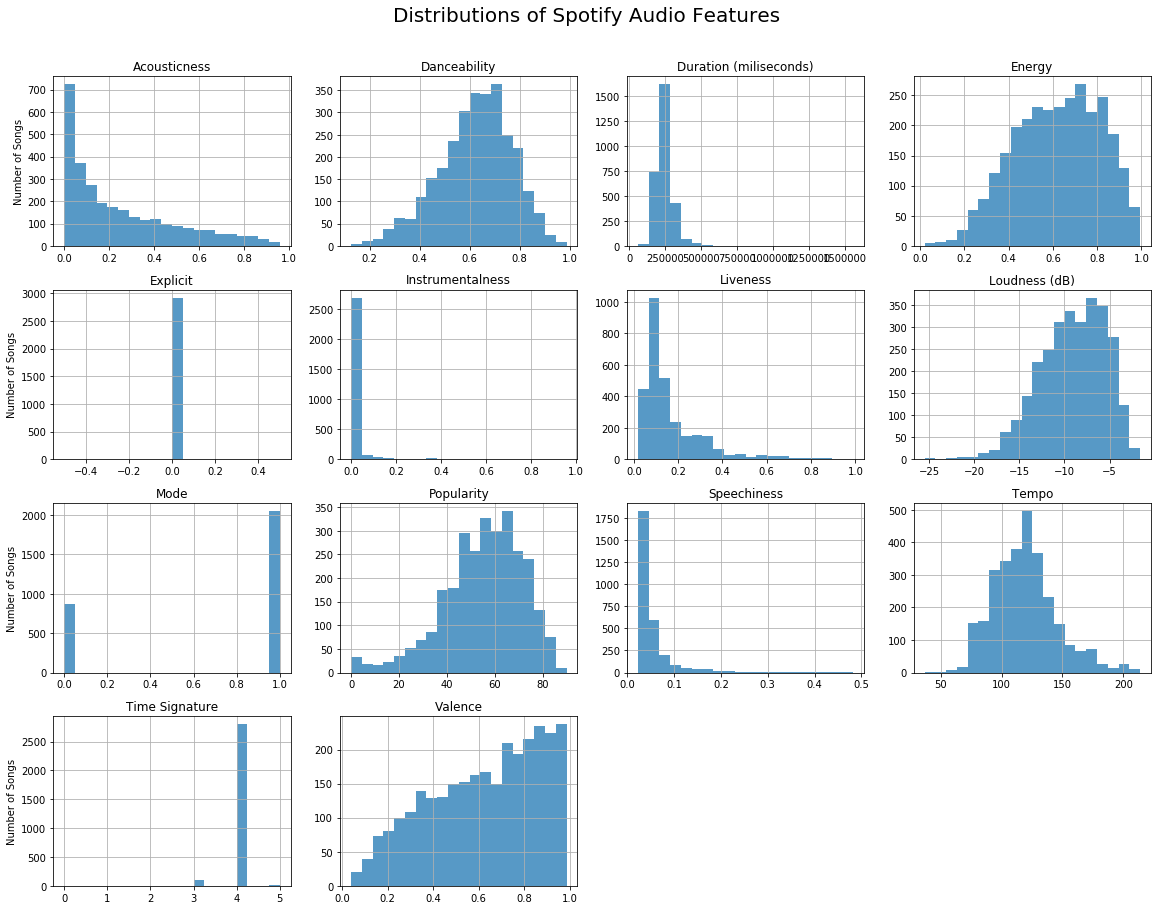

In [10]:
ax = df[['acousticness', 'danceability', 'duration_ms', 'energy',
           'explicit', 'instrumentalness', 'liveness', 'loudness', 'mode',
           'popularity', 'speechiness', 'tempo', 'time_signature', 'valence']].\
            hist(figsize=(16,12), bins=20, alpha=0.75);
ax = ax.ravel()
plt.tight_layout()

titles = ['Acousticness', 'Danceability', 'Duration (miliseconds)', 'Energy',
          'Explicit', 'Instrumentalness', 'Liveness', 'Loudness (dB)', 'Mode',
          'Popularity', 'Speechiness', 'Tempo', 'Time Signature', 'Valence']

for i in range(len(ax)-2):
    ax[i].set_title(titles[i])
    if i % 4 == 0:
        ax[i].set_ylabel('Number of Songs')
plt.suptitle('Distributions of Spotify Audio Features', fontsize=20, y=1.05);
plt.show()

### Correlation heatmap 

In [11]:
num_df_attributes = df[['acousticness', 'danceability', 'duration_ms', 'energy',
           'instrumentalness', 'liveness', 'loudness', 'mode',
           'popularity', 'speechiness', 'tempo', 'time_signature', 'valence']]

num_df_attributes.corr('spearman')['popularity']

acousticness       -0.152343
danceability        0.042441
duration_ms         0.032648
energy              0.129047
instrumentalness   -0.152428
liveness            0.001720
loudness            0.311193
mode               -0.060100
popularity          1.000000
speechiness         0.097810
tempo              -0.012831
time_signature      0.048770
valence            -0.128739
Name: popularity, dtype: float64

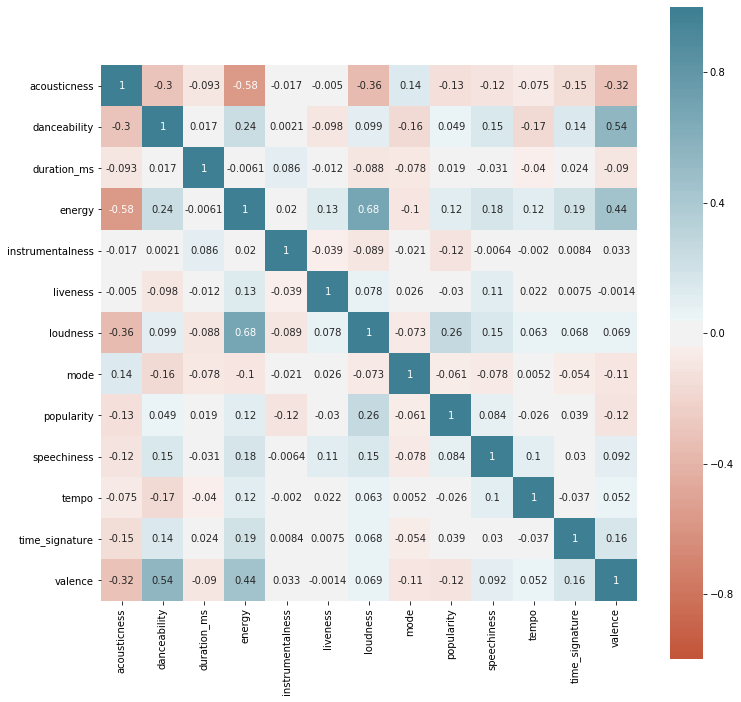

In [12]:
fig, ax = plt.subplots(figsize=(12,12))   
sns.heatmap(
    num_df_attributes.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    ax = ax
)

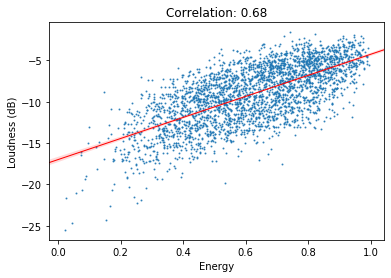

In [13]:
ax = sns.regplot(x=df['energy'], y=df['loudness'], line_kws= {'linewidth': 1, 'color': 'red'}, scatter_kws={'s': 1})
ax.set(title='Correlation: 0.68')
ax.set(xlabel='Energy', ylabel='Loudness (dB)')
plt.show()

### Boxplots over decades

In [14]:
audio_features=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
                'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

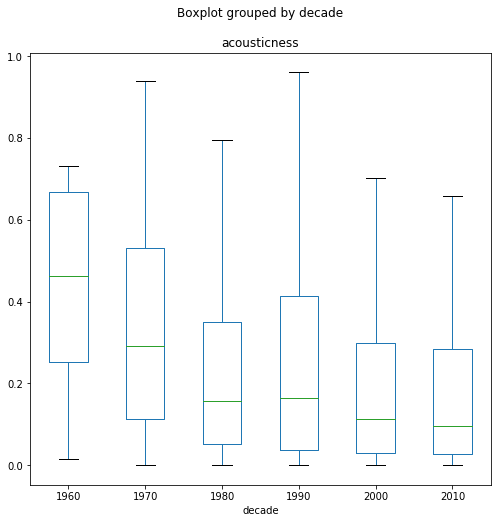

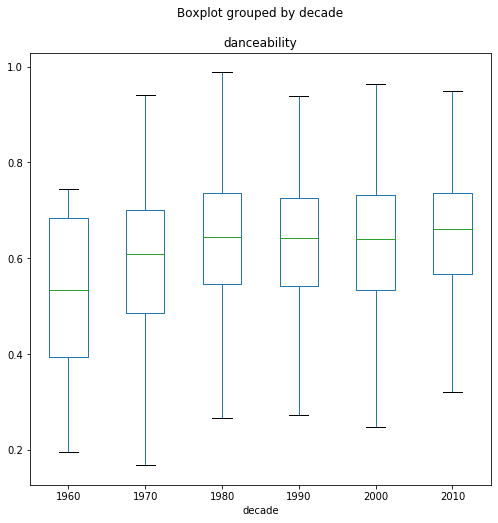

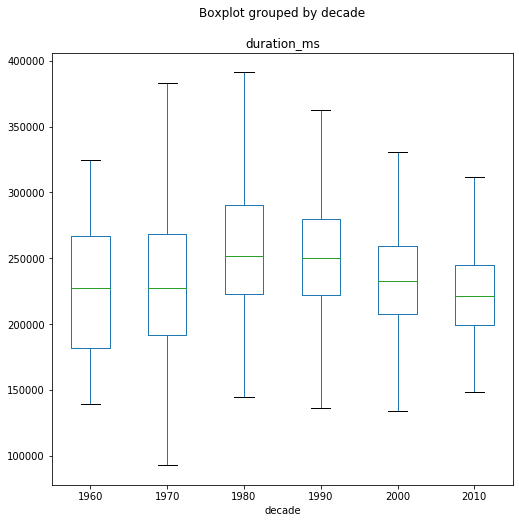

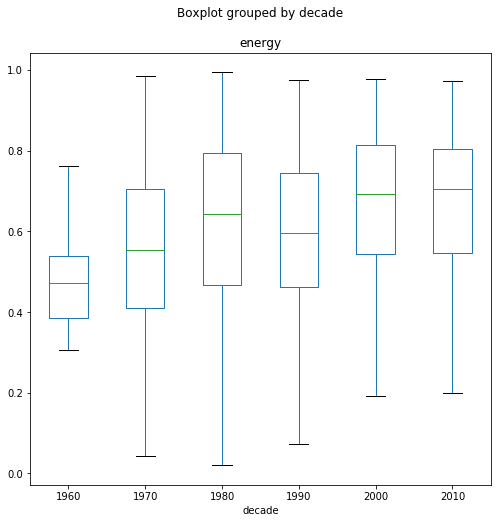

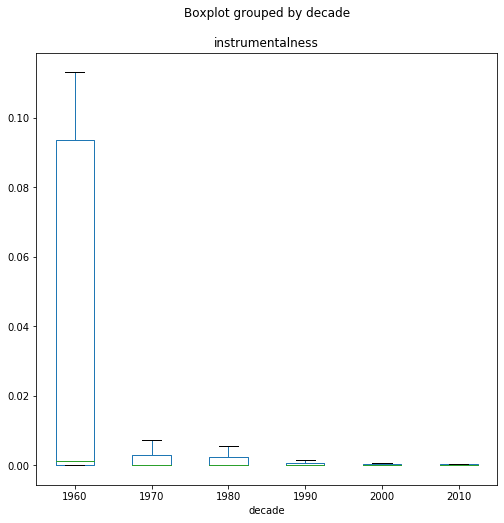

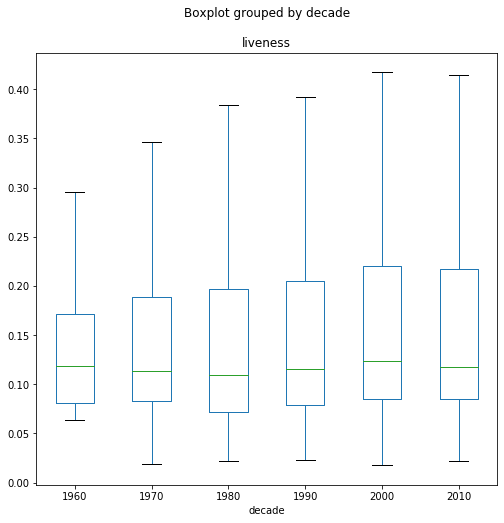

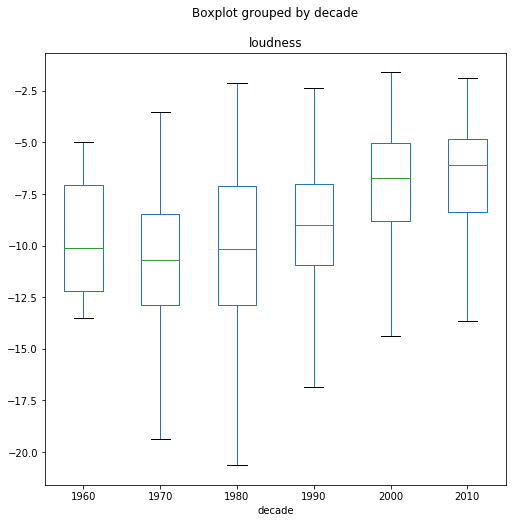

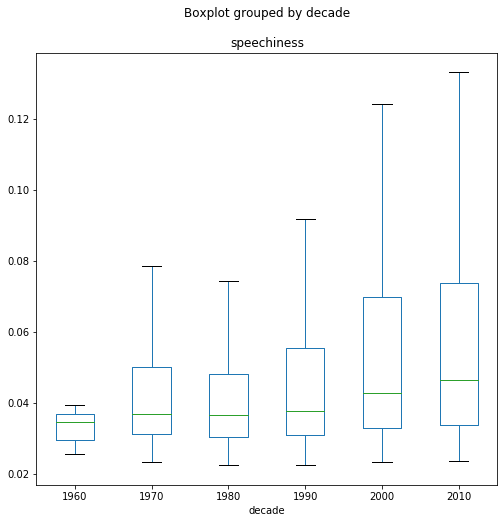

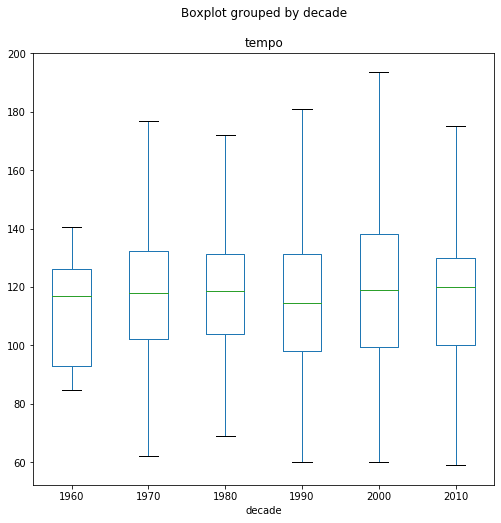

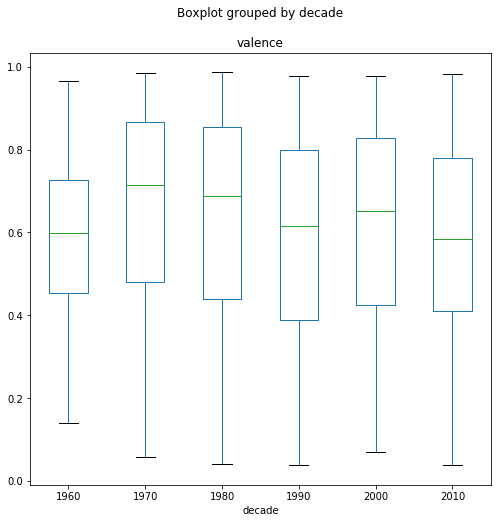

In [15]:
for feature in audio_features:
    fig, ax = plt.subplots(figsize=(8,8))
    plt.suptitle('')
    ax.grid(False)
    df.boxplot(column=[feature], by='decade', ax=ax, showfliers=False, grid=False)
    plt.show()

### Most populart artists

In [16]:
df['primary_artist'].value_counts().head(10)

Michael Jackson            27
Madonna                    27
Elton John                 24
Mariah Carey               19
Daryl Hall & John Oates    18
Stevie Wonder              18
Janet Jackson              17
Whitney Houston            16
Chicago                    14
Rihanna                    14
Name: primary_artist, dtype: int64

Text(0.5, 1.0, 'Most Popular Artists')

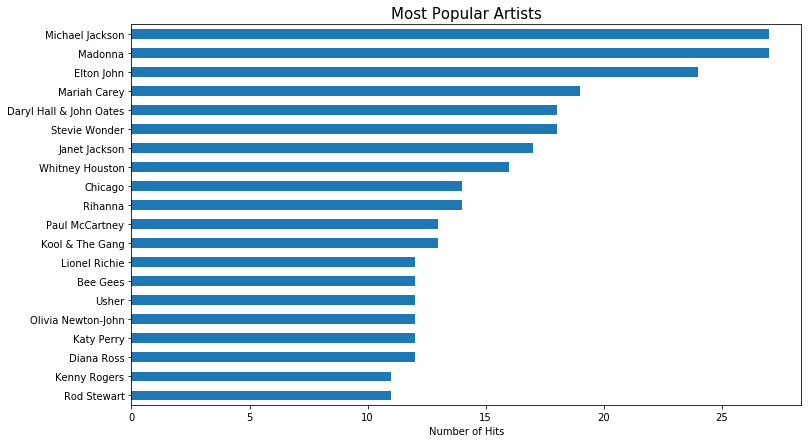

In [17]:
ax = df['primary_artist'].value_counts().sort_values().tail(20).plot.barh(figsize=(12,7))
ax.set(xlabel='Number of Hits')
ax.set_title('Most Popular Artists', fontsize=15)

In [18]:
top_artists = df.groupby('primary_artist')['name'].count()
top_artists = top_artists[top_artists >= 5]
audio_features=['acousticness', 'danceability', 'energy','instrumentalness', 
                'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
X_artists = df.groupby('primary_artist')[audio_features].mean()
X_artists = X_artists.reindex(top_artists.index)

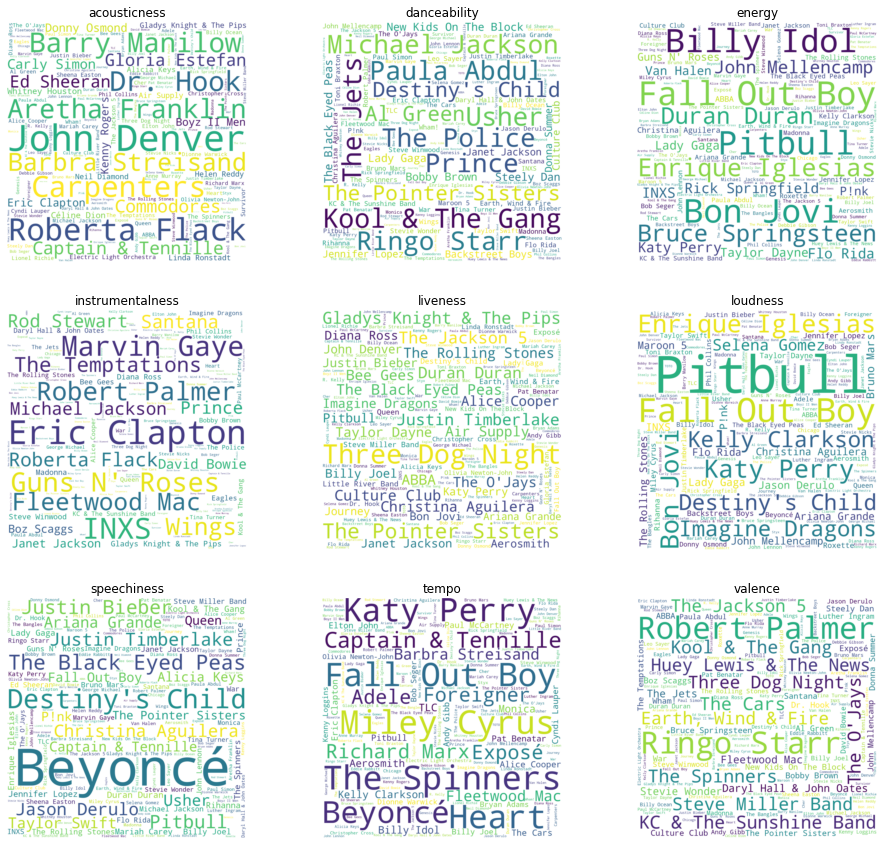

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(16,15))
ax = ax.ravel()

for i in range(len(audio_features)):
    # word-weight dictionary
    feature = X_artists[audio_features[i]] + 1e-3
    dictionary = dict(zip(X_artists.index, feature))
    
    wordcloud = WordCloud(background_color='white', height=1400, width=1400, min_font_size=5, max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title(audio_features[i])
    ax[i].axis('off')